## <center>Ensemble Learning with Random Forest Regression</center>

**Name: Elise Rattigan**<br>
**Last modified:** August 2021<br>

This project is adapted from one of the assignments in my Machine Learning unit at university, for which I received a mark of 100%.

The purpose of this project was to use ensemble learning on the **Wine Quality (red wine) dataset** from *UCI Machine Learning*, to predict the Quality values of the wine instances.

In this notebook, I will be training two Random Forest regressors, one first using all features, and then another one following feature selection, using only the features with importance above 5%.  I will be using `GridSearch` cross-validation to find the optimal hyperparameters, and then fitting the models. I will evaluate the performance of each Random Forest regressor by calculting the mean absolute error (MAE) and obtaining the raw prediction errors.

In [1]:
# Standard imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
%matplotlib inline

# Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Estimators
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Metrics
from sklearn.metrics import mean_absolute_error

## 1. Data Visualisation and Cleaning

The first step is to read in the data file and output a pandas DataFrame.

In [2]:
# Specify directory where data is located
data_dir = os.path.join('data', 'winequality-red.csv')

# Import data, which uses semicolon delimiters
redwine = pd.read_csv(data_dir, sep=';')

# Inspect first 5 lines of dataframe
redwine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [3]:
# Overview of the dataframe
redwine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


The above output shows there are 1599 observations in the dataset, and it has 12 attributes. The target attribute is `quality`, which is an integer. All the other attributes (predictors) are float-type variables.  There are no missing values.

There are a lot of variables in this dataset, so a scatter matrix will be too crowded and difficult to see the correlations between features. Therefore, I will visualise the dataset with a correlation heatmap.

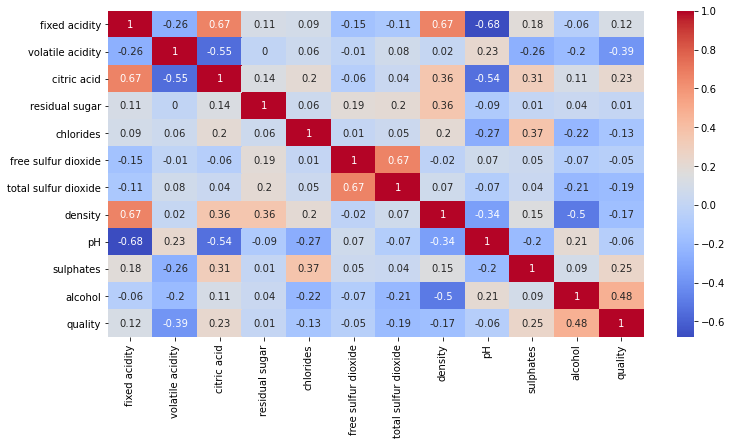

In [4]:
# Create correlation matrix
corr_matrix = redwine.corr()
fig, ax = plt.subplots(figsize=(12, 6))
sns.heatmap(round(corr_matrix,2), annot=True, ax=ax, cmap="coolwarm");

We can use the output above to observe any correlations between pairs of variables, particularly with the target variable. None of the variables have particularly high correlations with `quality`. The highest is `alcohol`, with a correlation of 0.48.

The highest correlation between predictor variables is `fixed acidity` and `pH`, which is -0.68. The next highest correlation is between `fixed acidity` and `citric acid`, with a value of 0.67. This is expected, as these variables are all logically related to one another.

## 2. Random Forest Regressor (full-dimensional data)

Now that I have inspected the data, I can prepare it for training the Random Forest regressor. I will use the `train_test_split` function from Scikit-Learn to randomly split the data into a training set and a test set, using an 85/15 split.

First, I will separate the target variable from the predictors using the function below.

In [5]:
# Function to prepare data
def prepare_data(df, target): 
    # Separate target variable from predictors
    X = df.drop(target, axis=1)
    y = df[target].values
    return X, y

In [6]:
# Apply function to prepare data
X, y = prepare_data(redwine, 'quality')

In [7]:
# Random seed for reproducibility
np.random.seed(100)

# Split into train and test set
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X, y, test_size = 0.15) # 85/15 split

In [8]:
print('There are {} instances in the training set.'.format(len(y_train_rf)))

There are 1359 instances in the training set.


In [9]:
print('There are {} instances in the test set.'.format(len(y_test_rf)))

There are 240 instances in the test set.


I will **not be implementing feature scaling** for the Random Forest Regressor, as it uses only Decision Trees as the base estimators, and Decision Trees are not affected by feature scaling.

For the Random Forest Regressor on the full-dimensional data, I will use `GridSearchCV` with 3-fold cross-validation to investigate optimal hyperparameters for both the base estimator and the ensemble itself. I will investigate the following hyperparameters:

* `max_depth`, which specifies the maximum tree depth of each of the base estimators. A large value leads to a large tree with many degrees of freedom, which may be too complex and overfit the data.
* `min_samples_leaf`, which specifies the minimum number of samples a leaf node must have in the base estimators. A small value may lead to too many nodes with too few samples, which could also cause overfitting.
* `max_samples`, which applies to the ensemble itself. When `bootstrap=True` (default) it limits the number of samples in the dataset used to build each tree. Calculated as a proportion (between 0 and 1).
* `n_estimators`, which specifies the number of Decision Trees in the Random Forest.

I will also use the hyperparameter `criterion=mse` for the base estimators, which means that at each split, the algorithm tries to choose the split which minimises the mean squared error.

I have commented out the below grid search code as it takes a long time to run. You can uncomment the code if you wish to run it again.

In [10]:
# Create grid of parameters to search
# rf_params = [{'criterion': ['mse'],
#               'max_depth': [2, 3, 4], 
#               'min_samples_leaf': [10, 20, 30], 
#               'max_samples': [0.5, 0.75, 1], 
#               'n_estimators': [100, 200, 500]}]

In [11]:
# Create RandomForestRegressor instance
# rf = RandomForestRegressor()

# Run GridSearchCV with grid of parameters, 3-fold cross-validation
# grid_search_rf = GridSearchCV(rf, rf_params, cv=3)

# Fit to training data
# grid_search_rf.fit(X_train_rf, y_train_rf)

In [12]:
# Get the best combination of parameters
# grid_search_rf.best_params_

When I ran the grid search code, the best hyperparameters applying to the base estimators were `max_depth` = 4 and `min_samples_leaf` = 10. The best hyperparameters for the ensemble were `n_estimators` = 200 (so 200 base Decision Trees in the Random Forest) and `max_samples` = 0.5 (so using 50% of the training data for each tree.

I will now fit a Random Forest regressor on the training data using these hyperparameters.

In [13]:
# Train Random Forest regressor on training set using the best parameters from original grid search
rf = RandomForestRegressor(criterion='mse', max_depth=4, min_samples_leaf=10, max_samples=0.5, n_estimators=200)
rf_reg = rf.fit(X_train_rf, y_train_rf)

Now that I have a fitted model, I can use it to make predictions, and evaluate the accuracy of those predictions by calculating the mean absolute errors. 

The function below accepts the model name, dataset and labels as input and generates predictions. The values of these predictions are cast as integers, rounded to the nearest whole number, as the wine quality values must be integers.  Using these predictions, I can then generate the mean absolute error.

In [14]:
# Function to generate predictions
# Takes in model, data (train or test) and labels (train or test)
def get_predictions(model, input_data, labels):
    # Make predictions and round to nearest integer
    pred = np.round(model.predict(input_data).astype(int))
    return pred

In [15]:
# Generate predictions for training and test sets
pred_train_rf = get_predictions(rf_reg, X_train_rf, y_train_rf)
pred_test_rf = get_predictions(rf_reg, X_test_rf, y_test_rf)

In [16]:
# Get MAE for training set predictions
mae_train_rf = mean_absolute_error(y_train_rf, pred_train_rf)
print('The mean absolute error (MAE) on the training set is: {}'.format(round(mae_train_rf, 3)))

The mean absolute error (MAE) on the training set is: 0.542


In [17]:
# Get MAE for test set predictions
mae_test_rf = mean_absolute_error(y_test_rf, pred_test_rf)
print('The mean absolute error (MAE) on the test set is: {}'.format(round(mae_test_rf, 3)))

The mean absolute error (MAE) on the test set is: 0.5


I ran this code a few times when creating this notebook, and found that the MAE scores varied each time it was run, so results may differ if the notebook is run again.  However, in general, based on the output I have seen, the MAE is generally around 0.54 for the training set and 0.5 for the test set. This is fairly low, and the fact that it is lower on the test set means the Random Forest Regressor generalises well and is not overfitting the training data.

We can also visualise the prediction results against the true values, as a scatter plot. I have created a function for this below. The function accepts the true values and predicted values for both the training and test data, as well as numbers for the xlim and ylim, so the graphs are shown on the same scale.

In [18]:
# Function to generate subplots of predictions v truth
# Takes in training labels, test labels, predictions on training and test sets, and some graph size specs

def pred_subplots(train_labels, test_labels, pred_train, pred_test, xlim, ylim, figsize):
    
    # Create the subplots
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=figsize)
    
    # Plot the data
    ax1.plot(train_labels, pred_train, 'b^', alpha=0.2)
    ax2.plot(test_labels, pred_test, 'rs', alpha=0.2)
    
    # Add line for true values   
    ax1.plot([train_labels.min(), train_labels.max()], [train_labels.min(), train_labels.max()], 'k--', lw=2)
    ax2.plot([test_labels.min(), test_labels.max()], [test_labels.min(), test_labels.max()], 'k--', lw=2)

    # Set the subplot titles
    ax1.set(title='Prediction results on training set')
    ax2.set(title='Prediction results on test set')

    for ax in fig.get_axes():
        ax.set(xlabel='True values',
           ylabel='Predicted values',
           xlim=xlim,
           ylim=ylim);
        
    return

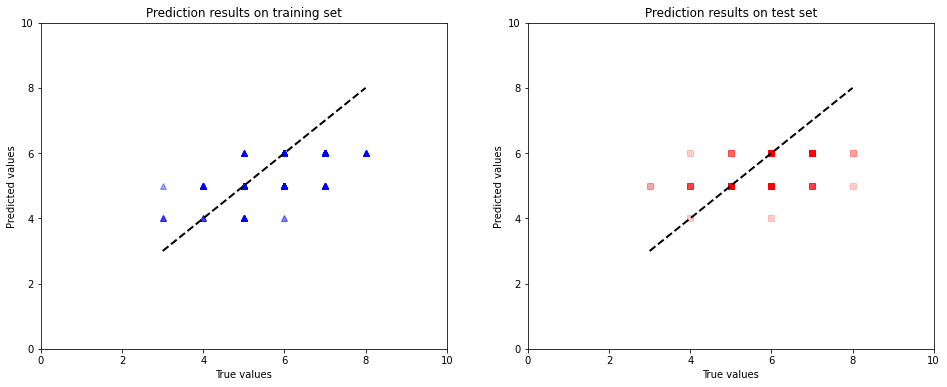

In [19]:
# Generate graphs from labels and predictions
pred_subplots(y_train_rf, y_test_rf, pred_train_rf, pred_test_rf, xlim=[0, 10], ylim=[0, 10], figsize=(16, 6))

It is quite difficult to interpret these plots as there are not many markers, so they appear quite spread out. This is because most of the values seem to fall within the same range of points, as demonstrated by the fact that most of the triangles/squares are a dark colour. But in general, it appears the prediction results were quite similar on both the training and test sets.

It does look as though the model has performed better on the test set, because the points further away from the line are quite pale, meaning few instances. However, there are obviously a lot more instances in the training set than on the test set, so this is not a good way to compare them.

Looking at the **raw prediction errors** may give us a better view of the model's performance. To get the raw prediction errors, I will simply take the difference (residual) of each true value and predicted value. I will then plot these residuals as a histogram.

I have created two functions below. The first one simply gets the residuals, as explained. The second function plots the residuals as histograms in two subplots, by calling the first function within it.  It accepts the true values and predicted values for both the training and test data, as well as a minimum and maximum value, which will determine the limits of the x-axis and the histogram bins, and an interval value to control the bin widths.

In [20]:
# Function to get residuals
def get_residuals(labels, pred):
    return pred - labels

In [21]:
# Function to plot raw prediction error histograms
# Takes in training labels, test labels, predictions on training and test sets, and some graph size specs

def plot_raw_errors(train_labels, test_labels, pred_train, pred_test, xmin, xmax, interval, figsize):
    
    # Create the subplots
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=figsize)
    
    # Get residuals using function
    train_residuals = get_residuals(train_labels, pred_train)
    test_residuals = get_residuals(test_labels, pred_test)
    
    # Plot the data
    ax1.hist(train_residuals, bins=np.arange(xmin, xmax, interval) - (interval/2), edgecolor="black")
    ax2.hist(test_residuals, bins=np.arange(xmin, xmax, interval) - (interval/2), edgecolor="black")
    
    # Set the subplot titles
    ax1.set(title='Raw prediction errors on training set')
    ax2.set(title='Raw prediction errors on test set')
    
    for ax in fig.get_axes():
        ax.set(xlabel="Raw prediction error (predicted - truth)",
               ylabel="Frequency",
               xlim=[xmin, xmax])        
    
    return

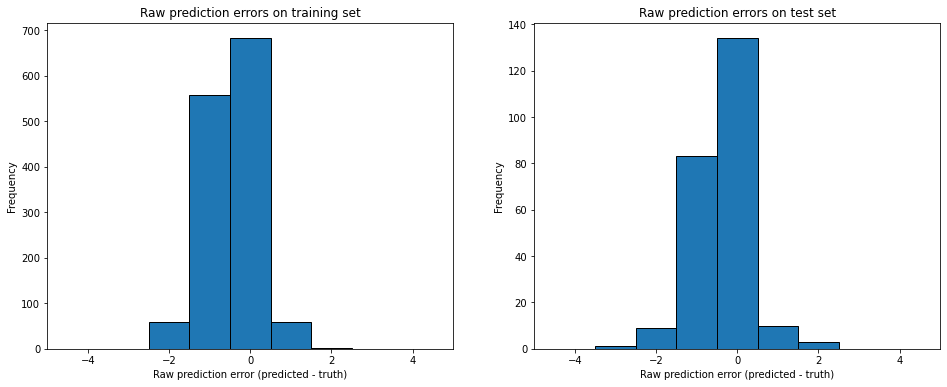

In [22]:
# Apply function to generate histograms
plot_raw_errors(y_train_rf, y_test_rf, pred_train_rf, pred_test_rf, xmin=-5, xmax=5, interval=1, figsize=(16, 6))

The histograms above show that the raw errors have a very similar distribution on both the training and test sets, supporting the view that the model generalises well and performs similarly on both. We can see that the raw errors range from about -2 to +2 for the training set and -3 to +2 for the test set. The training set seems to have proportionally more -1 errors than the test set, but the test set has proportionally more -3 and +2 errors. So it appears that the model predicted tended to predict lower than the truth on both datasets, but was generally closer to the truth on the training set.

Fortunately, the largest bin in both these histograms is for an error of 0, meaning the correct value was predicted the majority of the time. 

## 3. Feature Importance and Dimensionality Reduction

The next step is to obtain importances for the features in the training data and reduce the dimensions down to the most important features. I have created the following function, which gets the feature importance scores for each of the features in the training set and then makes two lists - one for features above the importance threshold and one for those below. It returns the list of features below the threshold, so that I can drop these from the training data.

The function accepts the data, the fitted model and a threshold value of importance above which the feature will be kept. For this project, I will be keeping features with importance >5%, so will use a threshold value of 0.05.

In [23]:
# Function to get feature importances and select features above threshold
def get_important_features(data, model, threshold):
    keep_list = []
    cum_score = 0
    drop_list = []
    
    print('The importances of all features in the dataset are:')
    # Loop through each feature importance
    for name, score in zip(data.columns, model.feature_importances_):
        # Print out all features and their scores for reference
        print('{}, score: {}'.format(name, round(score, 3)))
        
        # If greater than threshold, append to keep_list
        # And add score to cum_score
        if score > threshold:
            keep_list.append(name)
            cum_score += score
        # Else append to drop_list
        else:
            drop_list.append(name)
    
    print('\nThe features I will drop are: {}'.format(drop_list))
    print('\nThe features I will keep, with importances above {}, are: {}'.format(threshold, keep_list))
    print('\nThe total feature importance value retained after reduction will be {}, or {}%.'.format(round(cum_score, 3),
                                                                                                   (round(cum_score * 100, 1))))
    
    # Return list of features to drop
    return drop_list

In [24]:
# Apply function to see output and get list of features to drop
feat_sel = get_important_features(X_train_rf, rf_reg, 0.05)

The importances of all features in the dataset are:
fixed acidity, score: 0.021
volatile acidity, score: 0.147
citric acid, score: 0.027
residual sugar, score: 0.008
chlorides, score: 0.019
free sulfur dioxide, score: 0.012
total sulfur dioxide, score: 0.052
density, score: 0.008
pH, score: 0.017
sulphates, score: 0.195
alcohol, score: 0.494

The features I will drop are: ['fixed acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'density', 'pH']

The features I will keep, with importances above 0.05, are: ['volatile acidity', 'total sulfur dioxide', 'sulphates', 'alcohol']

The total feature importance value retained after reduction will be 0.888, or 88.8%.


I will create a second training set with just these three features deemed to be the most important (importance above 5%), and then use that training set to train another Random Forest Regressor.

In [25]:
# Create new training set by dropping unwanted features
X_train_rd = X_train_rf.drop(feat_sel, axis=1)

In [26]:
# View the training data
X_train_rd.head()

,volatile acidity,total sulfur dioxide,sulphates,alcohol
714,0.74,77.0,0.51,9.8
1183,0.66,61.0,0.60,9.3
701,0.65,25.0,0.67,9.5
1290,0.74,12.0,0.59,11.0
767,0.60,98.0,0.62,9.5


In [27]:
# Do the same on the test set
X_test_rd = X_test_rf.drop(feat_sel, axis=1)

## 4. Random Forest Regressor (reduced dimensional data)

I will now repeat the training and prediction processes on this reduced dimensional data. Just as I did for the full dimensional data, I will use `GridSearchCV` to investigate hyperparameters. To keep things consistent, I will conduct the search using the same parameters as for the full dimensional model, which I have already explained in detail. So these are: `max_depth`, `min_samples_leaf`, `max_samples` and `n_estimators`, and I will use `criterion=mse` for the base estimators.

Again, the grid search code has been commented out.

In [28]:
# Create RandomForestRegressor instance
# rf = RandomForestRegressor()

# Run GridSearchCV with same grid of parameters as previous model, 3-fold cross-validation
# grid_search_rf2 = GridSearchCV(rf, rf_params, cv=3)

# Fit to training data
# grid_search_rf2.fit(X_train_rd, y_train_rf)

In [29]:
# Get the best combination of parameters
# grid_search_rf2.best_params_

The results from the grid search were almost the same as for the full dimensional model. For the base estimators, the best hyperparameters were the same: `max_depth` = 4 and `min_samples_leaf` = 10. The best hyperparameters for the ensemble were slightly different from the full dimensional model, with `max_samples` = 0.5 but now with `n_estimators` = 500 (so 500 base Decision Trees in the Random Forest).

I will now fit a Random Forest regressor on the reduced dimension training data using these hyperparameters.

In [30]:
# Train Random Forest regressor on reduced dimension training data using the best parameters from original grid search
rf = RandomForestRegressor(criterion='mse', max_depth=4, min_samples_leaf=10, max_samples=0.5, n_estimators=500)
rf_reg_rd = rf.fit(X_train_rd, y_train_rf)

I can now use this fitted model to make predictions, calculate the mean absolute errors and the raw prediction errors. I will use the `get_predictions` function that I created previously.

In [31]:
# Generate predictions for training and test sets
pred_train_rd = get_predictions(rf_reg_rd, X_train_rd, y_train_rf)
pred_test_rd = get_predictions(rf_reg_rd, X_test_rd, y_test_rf)

In [32]:
# Get MAE for training set predictions
mae_train_rd = mean_absolute_error(y_train_rf, pred_train_rd)
print('The mean absolute error (MAE) on the training set is: {}'.format(round(mae_train_rd, 3)))

The mean absolute error (MAE) on the training set is: 0.543


In [33]:
# Get MAE for test set predictions
mae_test_rd = mean_absolute_error(y_test_rf, pred_test_rd)
print('The mean absolute error (MAE) on the test set is: {}'.format(round(mae_test_rd, 3)))

The mean absolute error (MAE) on the test set is: 0.504


From the output that I got when running the code, the MAE is again around 0.54 for the training set and 0.5 for the test set, so very similar to the results on the full dimensional data. Again, this is quite a good score, indicating the model has performed quite well on both datasets.

I will use the `pred_subplots` function I created earlier to visualise the prediction results against the true values, as a scatter plot.

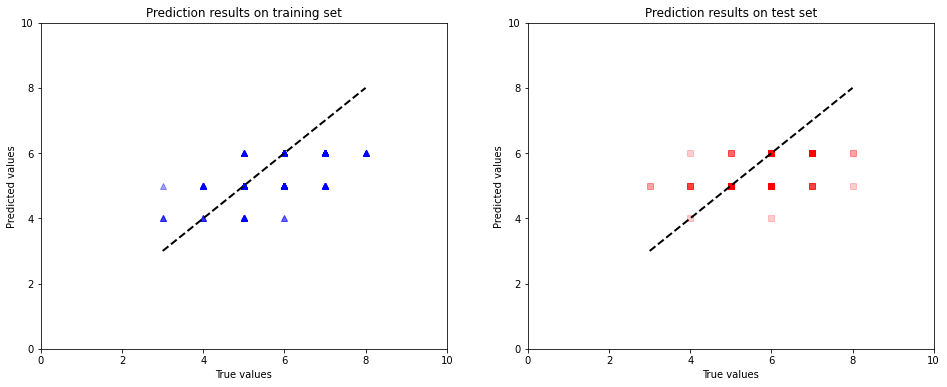

In [34]:
# Generate graphs from labels and predictions
pred_subplots(y_train_rf, y_test_rf, pred_train_rd, pred_test_rd, xlim=[0, 10], ylim=[0, 10], figsize=(16, 6))

Looking at these plots, they appear to be almost identical to the plots from the full dimensional data. Again, it is difficult to compare because the training set has more instances, but it does seem that on the test set, most of the points away from the central line are quite pale. As with the full dimensional data, it appears the prediction results were quite similar on both the training and test sets. I will compare the two in more detail at the end of this notebook.

Finally, I will reuse the function created previously to look at the raw prediction errors of the models as histograms.

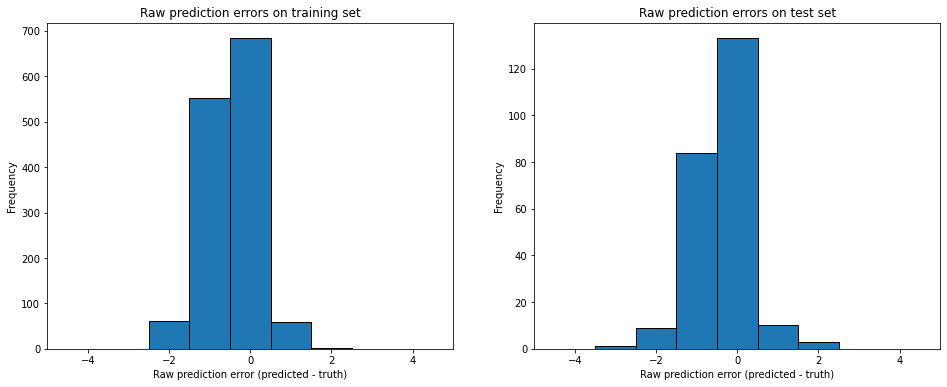

In [35]:
# Apply function to generate histograms
plot_raw_errors(y_train_rf, y_test_rf, pred_train_rd, pred_test_rd, xmin=-5, xmax=5, interval=1, figsize=(16, 6))

Looking at the histograms, as with the previous model, the raw errors have a very similar distribution on both datasets, ranging from about -2 to +2 on the training set and -3 to +2 for the test set, meaning the errors on the test set had more spread, but this is a very minimal difference. Again, for both histograms, the highest frequency is 0, for a correct prediction.

## 5. Comparison and Conclusion

I will now compare the performance of the full dimensional model with the reduced dimensional model.  For ease of reference when reading this comparison, I will show the two plots again below, so there is no need to keep scrolling back up the page to look at the graphs.

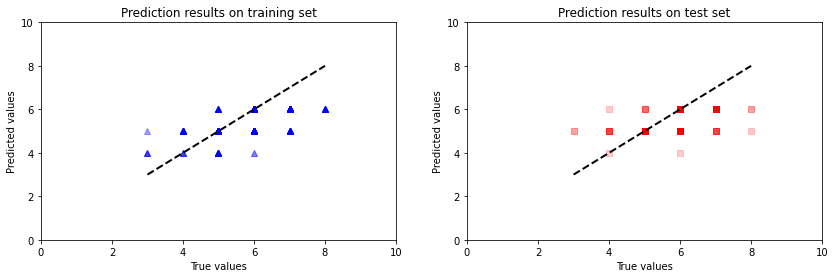

In [36]:
# Scatterplots for full dimensional model
pred_subplots(y_train_rf, y_test_rf, pred_train_rf, pred_test_rf, xlim=[0, 10], ylim=[0, 10], figsize=(14, 4))

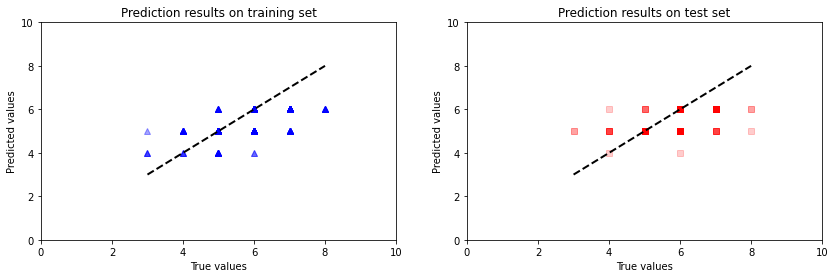

In [37]:
# Scatterplots for reduced dimensional model
pred_subplots(y_train_rf, y_test_rf, pred_train_rd, pred_test_rd, xlim=[0, 10], ylim=[0, 10], figsize=(14, 4))

There is very little visible difference between the predictions of the full and reduced dimensional models, indicating that the two models performed very similarly on both the training and test sets. Both models, on both datasets, tended to predict lower than the truth, most of the time, i.e. predicted 5 when the true value is 7.

This very close similarity suggests that retaining the three important features (keeping a total feature importance of around 88%), made little difference to the predictive power of the Random Forest regressor. However, this may be due to the fact that the reduced dimensional model had 500 base Decision Trees, compared with 200 in the full dimensional model. The reduced dimensional model may have been a weaker learner than the full model, but by combining more trees, it improved its performance.

Below are the histograms, shown again for easy comparison:

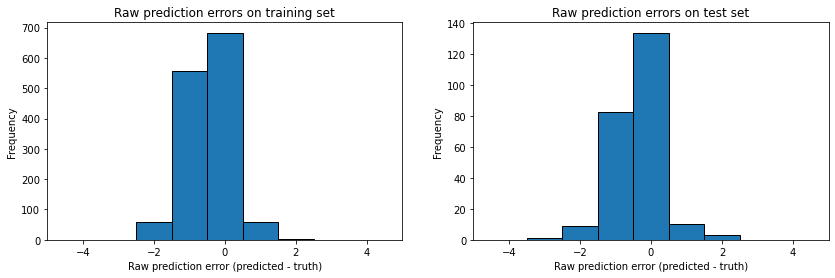

In [38]:
# Histograms for full dimensional model
plot_raw_errors(y_train_rf, y_test_rf, pred_train_rf, pred_test_rf, xmin=-5, xmax=5, interval=1, figsize=(14, 4))

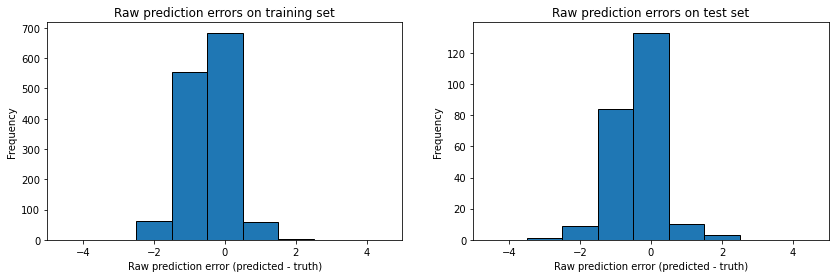

In [39]:
# Histograms for reduced dimensional model
plot_raw_errors(y_train_rf, y_test_rf, pred_train_rd, pred_test_rd, xmin=-5, xmax=5, interval=1, figsize=(14, 4))

There is also no visible difference between the full and reduced models when looking at the histograms above. Both models had a very similar spread of prediction errors on both datasets. The largest bin for all histograms is 0, meaning the majority of the time, both models predicted correctly on both datasets. The second largest bin in all histograms is an error of -1, meaning a prediction 1 less than the true value. Both models were slightly better at predicting closer to the truth on the training set than on the test set, as seen by the greater spread of values in the test set histograms.

Again, these similarities support the view that feature selection made little difference to the predictive power of the Random Forest regressor, possibly because of the number of trees in the reduced dimensional model. In general, both models performed well and are strong predictors, even on unseen test instances.